In [1]:
__author__ = 'Guillermo Damke <gdamke@gmail.com>, Mauricio Araya <maray@inf.utfsm.cl>' # single string; emails in <>
__version__ = '20200804' # yyyymmdd; version datestamp of this notebook
__datasets__ = []  # enter used datasets by hand
__keywords__ = ['Introduction to Machine Learning', 'Exploratory Analysis', 'La Serena School for Data Science']

<hr/>

# Practical Introduction to Machine Learning

*In original form by Mauricio Araya, Universidad Técnica Federico Santa María, Chile. Adaptated for DataLab by Guillermo Damke.*

<i><b>Credits:</b> Francisco Foster, Matthew Graham, Pavlos Protopapas</i>


#### This notebook is part of the curriculum of the 2019 La Serena School for Data Science

<hr/>
    
#### Topics to be covered in this notebook:
  
* Download and utilize astronomical data
* Regression: parametric and non-parametric
* Data labelling: Classification (supervised) and Clustering (unsupervised)
* Data characterization

## 1 - SDSS Data 
  
<img src="Figures/SDSS_telescope_new.jpg" alt="SLOAN" width="300">

We will download data from the Sloan Digital Sky Survey (SDSS), arguably the all-time favorite dataset for Machine Learning in Astronomy. We could have used data from UCI or Kaggle, but I think SDSS data is very appropaite for this school ;).

## 1.1 - Download Stellar Photometry Data using AstroML

We could access the SDSS data directly. Instead, we will start "cheating" a little bit by using the AstroML package.

AstroML is a popular library for "Machine Learning and Data Mining for Astronomy" and you can find more information in its website (https://www.astroml.org/)

In particular, we will download a dataset of RR Lyrae variable stars:

In [2]:
from astroML.datasets import fetch_rrlyrae_combined

sdss_star_feat, sdss_star_type = fetch_rrlyrae_combined()

and the fetched data come as Numpy arrays.

We will use the Pandas package to manage the data.

In [3]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=Warning)

%matplotlib inline
pd.set_option('display.max_rows',10)

and next we load the data into a Pandas DataFrame.

We need to define the column names, which are photometric colors in this case (i.e., the magnitude difference between two photometric filters).

In [4]:
star_feat=pd.DataFrame(sdss_star_feat)
star_feat.columns=['u-g', 'g-r', 'r-i', 'i-z']


We can do a plot of two columns of the dataset with Pandas: 

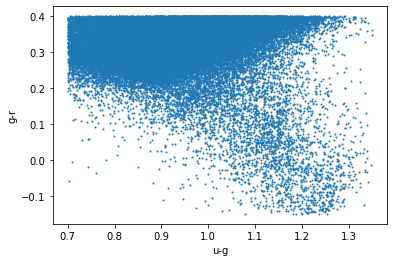

In [5]:
star_feat.plot.scatter('u-g', 'g-r', s=1) 

And also see quickly how the dataset looks like:

In [6]:
star_feat

,u-g,g-r,r-i,i-z
0,1.250999,0.394000,0.137000,0.061999
1,1.048000,0.339001,0.151999,0.023001
2,1.008001,0.341999,0.129000,0.203001
3,0.965000,0.392000,0.149000,0.150000
4,1.040001,0.333000,0.125999,0.101999
...,...,...,...,...
93136,0.962999,0.059000,-0.025999,-0.025000
93137,1.059999,0.185001,0.050999,-0.023998
93138,1.044001,0.212000,0.035000,0.002001
93139,1.064999,0.172001,0.042000,0.003000


In addition, the dataset also have associated *labels*. Labels usually indicate a *category* a single entry in the data can belong to.

Let's add the `sdss_star_type` data array as a column into the DataFrame. We can do this quickly because both star_feat and sdss_star_type already match.

In [7]:
star_feat['Type'] = sdss_star_type

And we can inspect the distribution of both groups in the same type of plot as above.
This is a "color-color" diagram, which is a usual way to present astronomical photometric data.

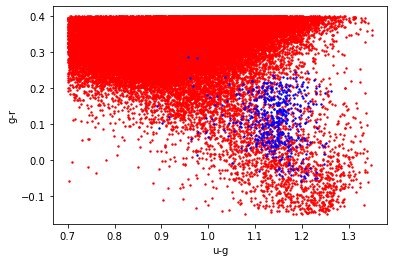

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
star_feat[star_feat['Type']==0].plot.scatter('u-g','g-r',c='red',ax=ax, s=2)
star_feat[star_feat['Type']==1].plot.scatter('u-g','g-r',c='blue',ax=ax, s=2)

## 1.2 - Download Galaxy Photometry Data (with Redshifts)

This dataset are galaxies with known (spectroscopically confirmed) redshifts and colour magnitudes. We're interested in determining the redshift of a galaxy from its colors (photometric redshift).

The data was provided by Dr. Matthew J. Graham (and was retrieved from: http://www.astro.caltech.edu/~mjg/sdss_gal.csv.gz). However, we have already placed it locally:

Again, we will load the data into a Pandas DataFrame:

In [9]:
galaxy_feat = pd.read_csv('/nbdata/sdss_gal.csv', low_memory=False)
galaxy_feat

,u-g,g-r,r-i,i-z,redshift
0,1.88235,0.95459,0.44631,0.32659,0.091214
1,1.97871,0.95931,0.46358,0.32285,0.117409
2,1.84007,0.92670,0.40268,0.32295,0.091852
3,1.89717,1.09666,0.47545,0.34684,0.153276
4,0.98144,0.38145,0.34404,0.04365,0.090731
...,...,...,...,...,...
1841292,1.76952,1.16660,0.57567,0.45292,0.091798
1841293,2.04845,1.07646,0.48183,0.41557,0.090638
1841294,1.19402,1.83407,1.08653,0.49640,0.567134
1841295,1.28313,1.80604,0.81906,0.51448,0.445512


It can be seen that the data contains almost 2 million entries (1,841,297 rows). We will use the "sample" function to get a random sample of the data and then plot them. This is a common way to inspect the distribution of data in large datasets. In addition, we will pass the "alpha" parameter to the plot function so that the points are semi-transparent.

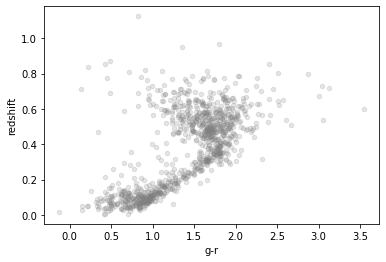

In [10]:
gal_sample = galaxy_feat.sample(n=1000)
gal_sample.plot.scatter('g-r','redshift',color='gray',alpha=0.2)

## 2 - Regression

Regression is about *predicting values of continous variables.*

$$y' = f(x' \mid \mathbf{X},\mathbf{y})$$

where $y \in \mathbb{R}^n$, $x \in \mathbb{R}^m$ and $\mathbf{y}$ and $\mathbf{X}$ are the target and non-target features for all the samples respectively. 

$y'$ is the result that we want to predict given a new $x'$.
In this case, we will use the SDSS Galaxy data (well... a portion of it) to predict *redshift* from the *g-r* color.

We split the `gal_sample` sample and split it as 0.75/0.25 for training/testing subsets (simple, but not correct).

In [11]:
train_data = gal_sample[:750]
test_data = gal_sample[750:]
y_train = train_data['redshift']
X_train = train_data['g-r']
# Formatting hack for training function...
print( f"X_train before reshape: shape: {X_train.shape}; ndim: {X_train.ndim}")
X_train=X_train.values.reshape(len(X_train), 1);
print( f"X_train after reshape: shape: {X_train.shape}; ndim: {X_train.ndim}")


X_train before reshape: shape: (750,); ndim: 1
X_train after reshape: shape: (750, 1); ndim: 2


## 2.1 - Parametric Regression

We can condense the information found in $\mathbf{X}$ and $\mathbf{y}$ by imposing a *parametric model*, meaning to *optimize* (also known as "fit") certain parameters for the given data. Now our model is
$$y' = f(x' ; \theta^*)$$
where 
$$\theta^* = \underset{\theta}{\operatorname{argmax}} \left\{ Pr(Y = f(X;\theta) \mid \mathbf{X}, \mathbf{y}) \right\}$$
which under a <b>linear model</b> and a Gaussian noise $\epsilon$ assumption ($Y = f(X) + \epsilon $) it becomes
$$ \theta^* = \underset{\theta}{\operatorname{argmin}} \left\{ \sum_i (y_i - f(X_i;\theta))^2 \right\}$$.

Consider now a straight line as our model,
$$ f(x;\theta) = a x + b$$
where our parameters are $\theta = \{a,b\}$.

We will use the linear model from `scikit-learn`

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import numpy as np

# Define an instance of regression:
regression = LinearRegression(fit_intercept=True)
regression.fit(X_train, y_train) # Optimize parameters (run the fit)

# And evaluate our model:
regression_line = lambda x: regression.intercept_ + regression.coef_ * x
print('The equation of the regression line is: y = {} + {} * x'.format(regression.intercept_, regression.coef_[0]))

The equation of the regression line is: y = -0.018441094072845665 + 0.2782367247587719 * x


Plot the model over the train data:


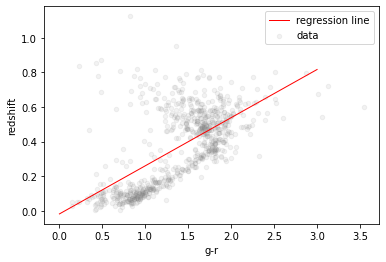

In [13]:
fig, ax = plt.subplots()
x_vals = np.linspace(0, 3, 100)

train_data.plot.scatter('g-r','redshift',color='gray',alpha=0.1,label='data',ax=ax)
ax.plot(x_vals, regression_line(x_vals), color='red', linewidth=1.0, label='regression line')
plt.legend()

Not very good... lets try another <b>linear</b> model!

$$ y = ax^2 + bx + c $$

Note that **linear** means "linear in its parameters" (a,b,c,d).


In [14]:
gen_poly_terms = PolynomialFeatures(degree=2)
X_train_with_poly = gen_poly_terms.fit_transform(X_train)
poly_regression = LinearRegression(fit_intercept=False)
poly_regression.fit(X_train_with_poly, y_train)
print( f"Coefficients: {poly_regression.coef_}")


Coefficients: [-0.10090795  0.41594874 -0.0498276 ]


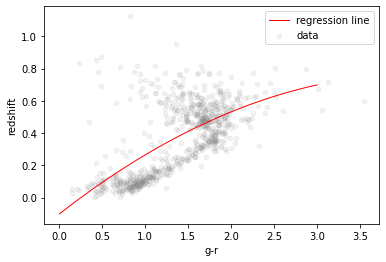

In [15]:
fig, ax = plt.subplots()
coef = poly_regression.coef_
poly = lambda x: coef[0] + coef[1] * x + coef[2] * x*x 
train_data.plot.scatter('g-r','redshift',color='gray',alpha=0.1,label='data',ax=ax)
ax.plot(x_vals, poly(x_vals), color='red', linewidth=1.0, label='regression line')
plt.legend()

Not very good either. Let's try a third linear model:

$$ y = ax^3 + bx^2 + cx + d $$


In [16]:
gen_poly_terms = PolynomialFeatures(degree=3)
X_train_with_poly = gen_poly_terms.fit_transform(X_train)
poly_regression = LinearRegression(fit_intercept=True)
poly_regression.fit(X_train_with_poly, y_train)
display(poly_regression.coef_)
poly_regression.intercept_

array([ 0.        ,  0.01572426,  0.22991218, -0.0574731 ])

0.059002208086925856

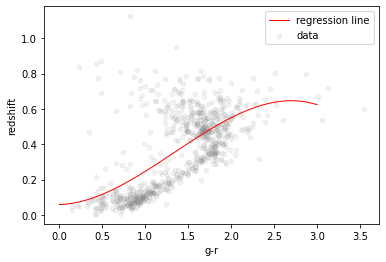

In [17]:
fig, ax = plt.subplots()
coef = poly_regression.coef_
inter = poly_regression.intercept_
poly = lambda x: inter + coef[1] * x + coef[2] * x*x + coef[3]*x*x*x
train_data.plot.scatter('g-r','redshift',color='gray',alpha=0.1,label='data',ax=ax)
ax.plot(x_vals, poly(x_vals), color='red', linewidth=1.0, label='regression line')
plt.legend()

Does it describe with our test data?

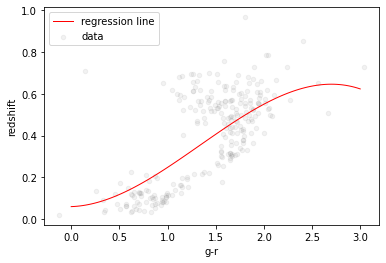

In [18]:
fig, ax = plt.subplots()
test_data.plot.scatter('g-r','redshift',color='gray',alpha=0.1,label='data',ax=ax)
ax.plot(x_vals, poly(x_vals), color='red', linewidth=1.0, label='regression line')
plt.legend()

We have basically *learned* the parameters!

This is not the best we can do of course!, we can:
* Change the function/model
* Use more dimensions
* Go non-linear...
* Use more/better data
* Use regularized models
* etc...

## 2.2 - Non-parametric Regression

Consolidating data into model parameters have some advantages and drawbacks. An alternative is to use *non-parametric* models. Now, we want to predict:

$$ y' = f(x'; \mathbf{X}, \mathbf{y}, \theta_0) $$

For example, consider a model based on assigning the same Gaussian function (Kernel) to each sample:

$$ K_\sigma(x)=\frac{1}{\sqrt{2\pi}\sigma}exp\left(\frac{-x^2}{2\sigma^2}\right)$$

so that:

$$ y'=\frac{\sum_{i=1}^n K_\sigma(x'-x_i)y_i}{\sum_{i=1}^nK_\sigma(x'-x_i)}$$

Please note that $\theta_0 = \sigma$.

Also, note that <b>non-parametric $\neq$ no parameters!</b>

In [19]:
# Define a Gaussian Kernel Regressor:
def GKR(x_predict, x_data, y_data, sigma):
    dmat = np.tile(x_data,len(x_predict))
    dmat = dmat - np.tile(x_predict,(len(x_data),1))
    K = np.exp(-(dmat*dmat)/(2*sigma*sigma))/(np.sqrt(2*np.pi)*sigma)
    return(K.T.dot(y_data) / K.sum(axis=0))

And let's build a funtion to explore how the effect of sigma in the model:

In [20]:
def plot_gkr(sigma=0.1):
    y_gkr=GKR(x_vals,X_train,y_train,sigma)
    fig, ax = plt.subplots()
    train_data.plot.scatter('g-r','redshift',color='gray',alpha=0.1,label='data',s=sigma*500,ax=ax)
    ax.plot(x_vals, y_gkr, color='red', linewidth=1.0, label='regression line')
    plt.legend()

In [21]:
from ipywidgets import interact
interact(plot_gkr,sigma=(0.01,1.0,0.01))

interactive(children=(FloatSlider(value=0.1, description='sigma', max=1.0, min=0.01, step=0.01), Output()), _d…

<function __main__.plot_gkr(sigma=0.1)>

However, there are much smarter ways to do this... for example Gaussian Processes! (which we will implement below)

## 3 - Labelling

Consider now the SDSS star photometry data. As we mentioned above, labels tell us about what category a datum belongs to.

Let's pick a training and a test samples in a 0.75/0.25 ratio.

<b>Warning:</b> we will do this *naively* (i.e., wrongly). We will improve this in other topics of the School...



In [22]:
N=2000
star_sample=star_feat[-1:-N-1:-1] # Pick the last 2000 elements.
star_sample = star_sample.sample(n=N) # Randomize
star_train = star_sample[:int(N*0.75)]
star_test = star_sample[int(N*0.75):]
star_train

,u-g,g-r,r-i,i-z,Type
92892,1.168001,0.156000,0.047000,-0.019000,1.0
91420,0.887001,0.371000,0.158998,0.050001,0.0
92688,1.114000,0.047001,-0.009001,0.000999,1.0
91177,1.137999,0.394001,0.146999,0.050000,0.0
92520,1.012999,0.350000,0.142000,0.069000,0.0
...,...,...,...,...,...
92968,1.151001,-0.024000,-0.052000,-0.065001,1.0
91563,1.135000,0.368999,0.122000,0.155001,0.0
91358,1.207001,0.184000,0.039999,-0.021000,0.0
92578,1.257000,0.162001,0.049999,-0.007999,0.0


Plot the training sample:

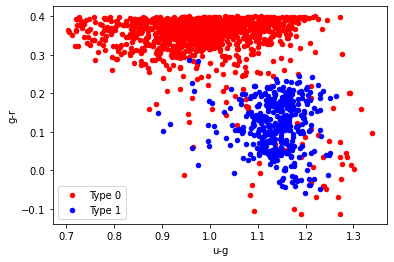

In [23]:
fig, ax = plt.subplots()
star_train[star_train['Type']==0].plot.scatter('u-g','g-r',c='red',ax=ax, label='Type 0')
star_train[star_train['Type']==1].plot.scatter('u-g','g-r',c='blue',ax=ax, label='Type 1')

and plot the test sample:

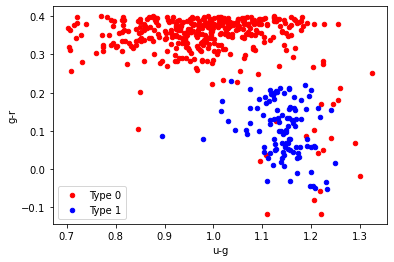

In [24]:
fig, ax = plt.subplots()
star_test[star_test['Type']==0].plot.scatter('u-g','g-r',c='red',ax=ax, label='Type 0')
star_test[star_test['Type']==1].plot.scatter('u-g','g-r',c='blue',ax=ax, label='Type 1')

What fraction does the `Type=1` class represent in each sample?

In [25]:
print( f"Fraction in star_train: {star_train['Type'].sum()/len(star_train)}")
print( f"Fraction in star_test: {star_test['Type'].sum()/len(star_test)}")
print( f"Fraction in star_feat: {star_feat['Type'].sum()/len(star_feat)}")

Fraction in star_train: 0.25
Fraction in star_test: 0.216
Fraction in star_feat: 0.005185686217669985


## 3.1 - Classification (Supervised)

Classification is *labelling based on previously annotated samples.*

### Discriminative Classification Models
Think on a boundary dividing data. The boundary divides data into classes. In 2 dimensions, the boundary is a line/curve; in 3 dimensions, a surface; in 4 dimensions, a volume; and so on. This is what is called a <b>discriminative model</b>. 

#### Support Vector Machines
*Vocabulary:* This is a  <font color='blue'>discriminative</font> <font color='green'>(non-parametric)</font> <font color='magenta'>linear</font> model for a <font color='red'>supervised</font> <font color='orange'>batch</font>  learning problem

This model is implemented in the `scikit-learn` package.

In [26]:
from sklearn.svm import SVC

clf = SVC(kernel='linear') # Create an instance of the model.
clf.fit(star_train[['u-g','g-r']], star_train['Type']) # Train the model.
y_pred = clf.predict(star_test[['u-g','g-r']]) # Predict the outcome using the test data.

add a column to the test data with the predicted values:

In [27]:
star_test['Predict'] = y_pred
star_test

,u-g,g-r,r-i,i-z,Type,Predict
91526,0.929001,0.372000,0.160000,0.084000,0.0,0.0
91885,0.945000,0.388000,0.148001,0.059999,0.0,0.0
92482,0.989000,0.372000,0.177000,0.132999,0.0,0.0
92076,0.924000,0.348001,0.133999,0.067001,0.0,0.0
91411,1.028999,0.349001,0.153999,0.058001,0.0,0.0
...,...,...,...,...,...,...
92644,1.063000,0.381001,0.159000,0.070000,0.0,0.0
93068,1.140001,0.067999,-0.019999,-0.024000,1.0,1.0
92154,0.954000,0.305000,0.124001,0.059999,0.0,0.0
92012,0.999001,0.285999,0.100000,0.024000,0.0,0.0


What fraction of the dataset is now predicted as Type=1?

In [28]:
print( f"Predicted fraction: {star_test['Predict'].sum()/len(star_test)}")

Predicted fraction: 0.258


As said above, a SVM will find a boundary that divides 2-dimensional data in two regions. Let's see what the model is:

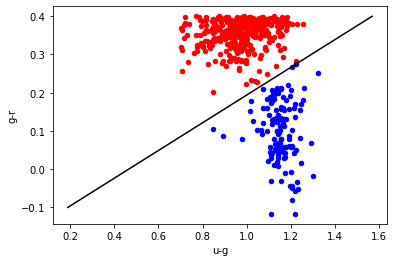

In [29]:
fig, ax = plt.subplots()
star_test[star_test['Predict']==0.0].plot.scatter('u-g','g-r',c='red',ax=ax)
star_test[star_test['Predict']==1.0].plot.scatter('u-g','g-r',c='blue',ax=ax)

# Compute the boundary
w = clf.coef_[0]
a = -w[1] / w[0]
yy = np.linspace(-0.1, 0.4)
xx = a * yy - clf.intercept_[0] / w[0]

ax.plot(xx, yy, '-k')

How well do the model perform in terms correctly predicting the class? We can plot the False Positives (FP), False Negatives (FN), True Positives (TP) and True Negatives (TN).

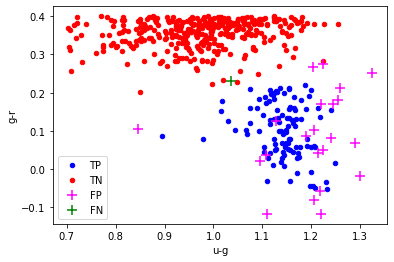

In [30]:
FP = star_test[star_test['Predict']==1.0]; FP = FP[FP['Type']==0.0]
FN = star_test[star_test['Predict']==0.0]; FN = FN[FN['Type']==1.0]
TP = star_test[star_test['Predict']==1.0]; TP = TP[TP['Type']==1.0]
TN = star_test[star_test['Predict']==0.0]; TN = TN[TN['Type']==0.0]
fig, ax = plt.subplots()
TP.plot.scatter('u-g','g-r',c='blue',ax=ax,label="TP")
TN.plot.scatter('u-g','g-r',c='red',ax=ax,label="TN")
FP.plot.scatter('u-g','g-r',c='magenta',ax=ax,label="FP",marker='+',s=100)
FN.plot.scatter('u-g','g-r',c='green',ax=ax,label="FN",marker='+',s=100)

#### Radial Basis Function Kernel
We can construct a hyperplane (line) in other space by transforming data to that space, and then come back. This is done using kernels

$${\displaystyle K(\mathbf {x} ,\mathbf {x'} )=\exp \left(-{\frac {\|\mathbf {x} -\mathbf {x'} \|^{2}}{2\sigma ^{2}}}\right)}$$

In [31]:
from scipy.ndimage import gaussian_filter
def plot_svm_rbf(gamma=20.0):
    clf_rbf = SVC(kernel='rbf', gamma=gamma)
    clf_rbf.fit(star_train[['u-g','g-r']], star_train['Type'])
    y_pred_rbf = clf_rbf.predict(star_test[['u-g','g-r']])
    star_test['PredictRBF']=y_pred_rbf
    xlim = (0.7, 1.35)
    ylim = (-0.15, 0.4)
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101),
                     np.linspace(ylim[0], ylim[1], 101))
    Z = clf_rbf.predict(np.c_[ xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = gaussian_filter(Z, 2)
    FP = star_test[star_test['PredictRBF']==1.0]; FP = FP[FP['Type']==0.0]
    FN = star_test[star_test['PredictRBF']==0.0]; FN = FN[FN['Type']==1.0]
    TP = star_test[star_test['PredictRBF']==1.0]; TP = TP[TP['Type']==1.0]
    TN = star_test[star_test['PredictRBF']==0.0]; TN = TN[TN['Type']==0.0]
    fig, ax = plt.subplots()
    TP.plot.scatter('u-g','g-r',c='red',ax=ax,label="TP")
    TN.plot.scatter('u-g','g-r',c='blue',ax=ax,label="TN")
    FP.plot.scatter('u-g','g-r',c='green',ax=ax,label="FP",marker='+',s=100)
    FN.plot.scatter('u-g','g-r',c='magenta',ax=ax,label="FN",marker='+',s=100)
    ax.contour(xx, yy, Z, [0.5], colors='k')

In [32]:
interact(plot_svm_rbf,gamma=(0.1,300,10))

interactive(children=(FloatSlider(value=20.0, description='gamma', max=300.0, min=0.1, step=10.0), Output()), …

<function __main__.plot_svm_rbf(gamma=20.0)>

## 3.2. Clustering (Unsupervised)

Now think trying to put labels but without knowing previous examples on the Galaxy data... but using now all the dimensions (i.e., all photometric colors)!

*Clustering* permits us to find groups of objects that represent candidate categories. Clustering encompass techniques of *unsupervised learning* that allows us to explore the dataset.

In [33]:
gal_sample

,u-g,g-r,r-i,i-z,redshift
86422,2.46219,1.14188,0.50228,0.44943,0.125864
843731,1.68480,0.63696,0.36389,0.19513,0.073370
778982,1.80693,0.88478,0.47073,0.33296,0.073530
1215591,0.45659,3.12573,1.35518,0.64226,0.719684
1815442,0.46692,1.62479,0.81168,0.38756,0.433932
...,...,...,...,...,...
1828150,3.16942,1.55407,0.89866,0.45202,0.554504
460138,0.83549,0.62276,0.31716,0.27473,0.224153
987530,0.84747,1.88565,0.95755,0.37561,0.521385
1218417,-0.05216,2.02590,1.28281,0.80781,0.785086


Plot the data in all the photometric colors:

In [34]:
def gal_4proj(axes):
    ((ax1, ax2), (ax3, ax4)) = axes
    gal_sample.plot.scatter('u-g','redshift',color='gray',alpha=0.1,ax=ax1)
    gal_sample.plot.scatter('g-r','redshift',color='gray',alpha=0.1,ax=ax2)
    gal_sample.plot.scatter('r-i','redshift',color='gray',alpha=0.1,ax=ax3)
    gal_sample.plot.scatter('i-z','redshift',color='gray',alpha=0.1,ax=ax4)

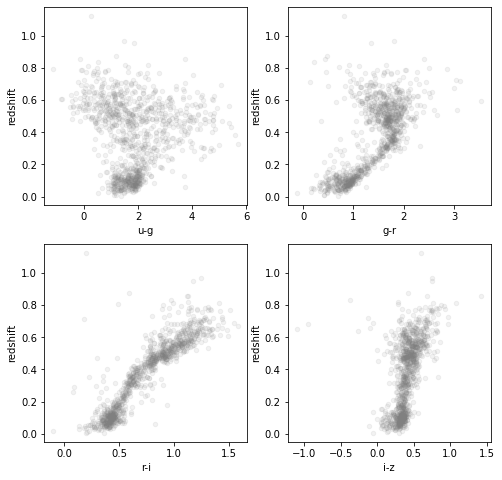

In [35]:
fig, axes = plt.subplots(2,2, figsize=(8,8))
gal_4proj(axes)

### Gaussian Mixture Model 

Consider a Gaussian Mixture Model:

$$ \mathcal{N}(x; \mu, \Sigma) = \frac{\exp \left(-{\frac{1}{2}}( x - \mu )^{\mathrm {T}}\Sigma^{-1}(x - \mu )\right)}{\sqrt {(2\pi )^{k}|\Sigma| }}$$
$$ p(x) = \displaystyle\sum_{j=1}^{k} \phi_j\mathcal{N}(x; \mu_j, \Sigma_j)$$
$$\displaystyle\sum_{j=1}^{k} \phi_j = 1 $$

Such a model is implemented in `Scikit-learn`:

In [36]:
from sklearn.mixture import GaussianMixture
colors = ['red','blue','green','magenta','cyan','orange']

def clust_4proj(mix,axes,n):
    for dim in range(4):
        ax = axes[int(dim/2),dim%2]
        labels=mix.predict(gal_sample)
        for i in range(n):
            gal_sample[labels==i].plot.scatter(dim,'redshift',color=colors[i],alpha=0.1,ax=ax)

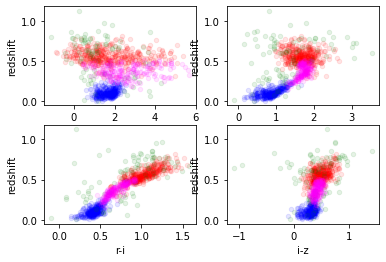

In [37]:
n = 4 # Set number of clusters:
mix = GaussianMixture(n_components=n,covariance_type='full', max_iter=100)
mix.fit(gal_sample)
fig, axes =plt.subplots(2,2)
clust_4proj(mix,axes,n)

*Vocabulary:* This is a <font color='blue'>generative</font> <font color='green'>parametric</font> <font color='magenta'>linear</font> model for a <font color='red'>unsupervised</font> <font color='orange'>batch</font>  learning problem

Let's plot the clusters found by the GMM, as a function of the number of clusters *n*:

In [38]:
import matplotlib as mpl
def GMM_4proj(gmm,axes,n):
    for clust in range(n):
        for dim in range(4):
            dims=[dim,4]
            ax = axes[int(dim/2),dim%2]
            cov = gmm.covariances_[clust]
            cov = cov[dims][:,dims]
            v, w = np.linalg.eigh(cov)
            u = w[0] / np.linalg.norm(w[0])
            angle = np.arctan2(u[1], u[0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            ell = mpl.patches.Ellipse(gmm.means_[clust,dims], v[0], v[1],
                     180 + angle, color=colors[clust])
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.3)
            ax.add_artist(ell)

In [39]:
def show_clusters(n=2): # Set initial n=2
    mix = GaussianMixture(n_components=n,covariance_type='full', max_iter=100)
    mix.fit(gal_sample)
    fig, axes =plt.subplots(2,2)
    gal_4proj(axes)
    GMM_4proj(mix,axes,n)

Use the slider to change the number of clusters interactively!

In [40]:
interact(show_clusters,n=(2,6,1))

interactive(children=(IntSlider(value=2, description='n', max=6, min=2), Output()), _dom_classes=('widget-inte…

<function __main__.show_clusters(n=2)>

## 4.- Characterizing

#### Dimensionality Reduction (PCA)

*Principal Component Analysis (PCA)* is a technique used to reduce the dimmensionality of the data.

Consider the Singular Value Decomposition of your data (in matrix form):

$$\mathbf{X} = \mathbf{U}\mathbf{\Sigma}\mathbf{W}^T$$

Then, you can compute an affine transformation of your data such that:

$${\displaystyle {\begin{aligned}\mathbf {X} ^{T}\mathbf {X} &=\mathbf {W} \mathbf {\Sigma } ^{T}\mathbf {U} ^{T}\mathbf {U} \mathbf {\Sigma } \mathbf {W} ^{T}\\&=\mathbf {W} \mathbf {\Sigma } ^{T}\mathbf {\Sigma } \mathbf {W} ^{T}\\&=\mathbf {W} \mathbf {\Sigma'}\mathbf {W} ^{T}\end{aligned}}}$$

Meaning that:

$$\begin{align}
\mathbf{T} & = \mathbf{X} \mathbf{W} \\
           & = \mathbf{U}\mathbf{\Sigma}\mathbf{W}^T \mathbf{W} \\
           & = \mathbf{U}\mathbf{\Sigma}
\end{align}$$

PCA for dimensionality reduction is basically:

$$ \mathbf{T}_L = \mathbf{U}_L\mathbf{\Sigma}_L = \mathbf{X} \mathbf{W}_L  $$

In [41]:
n=4
mix = GaussianMixture(n_components=n,covariance_type='full', max_iter=100)
mix.fit(gal_sample)
labels=mix.predict(gal_sample) 

We will use the implementation of PCA from `scikit-learn`:

In [42]:
from sklearn import decomposition

In [43]:
pca = decomposition.PCA(n_components=3)
pca.fit(gal_sample)
lowd = pca.transform(gal_sample)

In [44]:
print( f"We reduced the dataset dimensionality from {gal_sample.shape[1]} to {lowd.shape[1]} dimensions.")

We reduced the dataset dimensionality from 5 to 3 dimensions.


Let's plot the 3 principal components in 3D, color-coded by the four clusters found using Gaussian Mixture. Use the cursor to move the cube.

<IPython.core.display.Javascript object>


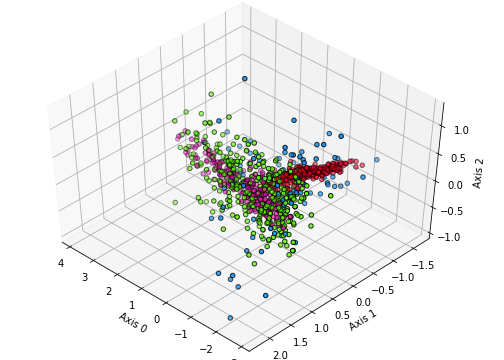

Text(0.5, 0, 'Axis 2')

In [49]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(7, 5))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(lowd[:, 0], lowd[:, 1], lowd[:, 2], c=labels, cmap=plt.cm.gist_rainbow,
           edgecolor='k')
ax.set_xlabel("Axis 0")
ax.set_ylabel("Axis 1")
ax.set_zlabel("Axis 2")

How are the original 5 dimensions related to the 3 components in the PCA? We can print the the coefficients of the 5 input columns with respect of the 3 new axes:

In [46]:
pca_comp = pd.DataFrame(pca.components_)
pca_comp.columns = [['u-g', 'g-r', 'r-i', 'i-z','redshift']]
pca_comp

,u-g,g-r,r-i,i-z,redshift
0,0.995534,0.093140,0.008751,0.012579,-0.001351
1,-0.082023,0.815730,0.448298,0.173112,0.311316
2,0.046244,-0.566167,0.657122,0.126574,0.479046


As a test, we can check if the the reduced dimensions in the PCA keep the original clusters in the data.

We will apply the Gaussian Mixture Model with 4 components to the PCA results:

In [47]:
mix = GaussianMixture(n_components=n,covariance_type='full', max_iter=100)
mix.fit(lowd)
labels_low = mix.predict(lowd)

Let's plot the new labels. Compare to the previous Figure!

<IPython.core.display.Javascript object>


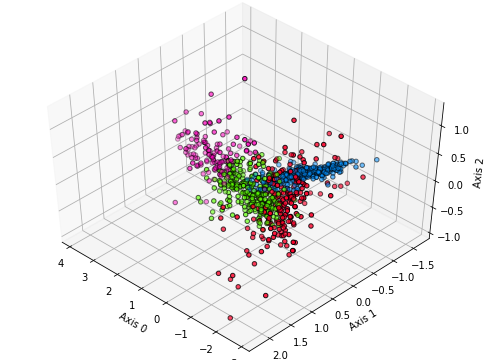

In [50]:
fig = plt.figure(1, figsize=(7, 5))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(lowd[:, 0], lowd[:, 1], lowd[:, 2], c=labels_low, cmap=plt.cm.gist_rainbow,
           edgecolor='k')
ax.set_xlabel("Axis 0")
ax.set_ylabel("Axis 1")
ax.set_zlabel("Axis 2")
plt.show()

### Summary

In this practical introduction, we have used data from the SDSS to introduce 3 usual tasks performed in Data Science, namely, Regression, Classification and Clustering, and dimensionality reduction through PCA.